# The social network of Caesar's *Bellum Gallicum*

## Data Flow

The data will be collected from a reduced version (extracts) of the *Bellum Gallicum*, which has been manually annotated for morphology and syntax according to the Universal Dependency model, in the CoNLL-U format.

See the [GitHub repository](https://github.com/proiel/proiel-treebank/blob/master/caes-gal.conll).

### The components of the CoNLL-U annotation schema

CoNLL-U annotations are distributed as plain text files.

The annotation files contain three types of lines: **comment lines**, **word lines** and **blank lines**.

**Comment lines** precede word lines and start with a hash character (#). These lines can be used to provide metadata about the word lines that follow.

Each **word line** contains annotations for a single word or token. Larger linguistic units are represented by subsequent word lines.

The annotations for a word line are provided using the following fields, each separated by a tabulator character:

```console
ID	FORM	LEMMA	UPOS	XPOS	FEATS	HEAD	DEPREL	DEPS	MISC
```

 1. `ID`: Index of the word in sequence
 2. `FORM`: The form of a word or punctuation symbol
 3. `LEMMA`: Lemma or the base form of a word
 4. `UPOS`: [Universal part-of-speech tag](https://universaldependencies.org/u/pos/)
 5. `XPOS`: Language-specific part-of-speech tag
 6. `FEATS`: [Morphological features](https://universaldependencies.org/u/feat/index.html)
 7. `HEAD`: Syntactic head of the current word
 8. `DEPREL`: Universal dependency relation to the `HEAD`
 9. `DEPS`: [Enhanced dependency relations](https://universaldependencies.org/u/overview/enhanced-syntax.html)
 10. `MISC`: Any additional annotations

Finally, a **blank line** after word lines is used to separate sentences.

For reading and managing the CoNNL-U formatted file, we will use Python [conllu](https://pypi.org/project/conllu/) library.

In [134]:
# Import the conllu library
import conllu

In [135]:
# Open the plain text file for reading; assign under 'data'
with open('caes_gal.conllu', mode="r", encoding="utf-8") as data:

    # Read the file contents and assign under 'annotations'
    annotations = data.read()
# Use the parse() function to parse the annotations; store under 'sentences'
sentences = conllu.parse(annotations)

The parse() function returns a Python list populated by TokenList objects, native to pyconll library.

In [136]:
# print the first token (TokenList object) of the first sentence (list).
sentences[0][0]

{'id': 1,
 'form': 'Gallia',
 'lemma': 'Gallia',
 'upos': 'PROPN',
 'xpos': 'Ne',
 'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
 'head': 4,
 'deprel': 'nsubj:pass',
 'deps': None,
 'misc': {'Ref': '1.1.1'}}

### Named Entities extraction

First of all, we want to extract the NE from the annotations. Although proper nouns are already marked as such in `annotations`, we don't need to perform an actual NE recognition. Nevertheless, since sentences are annotated token-by-token, in case of multi-token names we need to group the tokens that are associated with the same entity, i.e. are part of the full name of a character. To do so, we can rely on the consistency of the annotation procedure, for which the "second names" are marked as direct dependants of the "first name" token by a 'flat:name' relation.

In [137]:
def get_ne(sentences:list):
    full_names = []
    for sent in sentences:
        visited_tokens = []
        for token in sent:
            if token['xpos'] == 'Ne' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    multi_token_name = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    full_names.append(multi_token_name)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    full_names.append([token])
    return full_names

In [138]:
ne_instances = get_ne(sentences)

In [139]:
ne_tok_instances_set = [l[0] for l in ne_instances]


In [140]:
ne_tok_instances_set

[{'id': 1,
  'form': 'Gallia',
  'lemma': 'Gallia',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
  'head': 4,
  'deprel': 'nsubj:pass',
  'deps': None,
  'misc': {'Ref': '1.1.1'}},
 {'id': 4,
  'form': 'Garumna',
  'lemma': 'Garumna',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'head': 1,
  'deprel': 'nsubj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 8,
  'form': 'Matrona',
  'lemma': 'Matrona',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'head': 11,
  'deprel': 'nsubj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 10,
  'form': 'Sequana',
  'lemma': 'Sequana',
  'upos': 'PROPN',
  'xpos': 'Ne',
  'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing'},
  'head': 8,
  'deprel': 'conj',
  'deps': None,
  'misc': {'Ref': '1.1.2'}},
 {'id': 36,
  'form': 'Rhenum',
  'lemma': 'Rhenus',
  'upos': 'PROPN'

In [141]:
import itertools
from pprint import pprint
from collections import defaultdict

In [142]:
def get_relations(sentences:list):

    global_relations = []
    # all_full_names = []
    for sent in sentences:
        relations_in_sentence = []
        entities_in_sent = []
        visited_tokens = []
        for token in sent:
            if token['upos'] == 'PROPN' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    fullname = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    fullname = [token]
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    visited_tokens.append(fullname)

        pairs = list(itertools.combinations(entities_in_sent, 2))

        for pair in pairs:
            ent1 = pair[0]
            ent2 = pair[1]
            value = 1


            if ent1[0]['head'] == ent2[0]['head'] or (ent1[0]['head'] == ent2[0]['id'] or ent2[0]['head'] == ent1[0]['id']):
                value += 2

            if value is not None:
                relation = {'ent1':ent1, 'ent2': ent2, 'value': value}
                relations_in_sentence.append(relation)

        if relations_in_sentence:
            global_relations.append(relations_in_sentence)

    return global_relations

In [143]:
relations_instances = get_relations(sentences)

## Process relations instances

In the script below, the list of relations, in which each entity's occurence is represented by its TokenList object, is processed to obtain a list of tuples, `final_relations`, each of which consists in the weighted edge of the graph that will be built.

In [144]:
tmp_relations = []
for rels_in_sent in relations_instances:

    for rel in rels_in_sent:

        ent1 = ' '.join([i['lemma'] for i in rel['ent1']])
        ent2 = ' '.join([i['lemma'] for i in rel['ent2']])

        value = rel['value']

        row = (ent1, ent2, value)
        tmp_relations.append(row)

# create a defaultdict to store the sums
sums = defaultdict(int)

# loop through the tuples and add the third element to the sum
# for the corresponding first two elements
for t in tmp_relations:
    sums[(t[0], t[1])] += t[2]

# create a new list of tuples with the first two elements as the key
# and the sum as the value
final_relations = [(k[0], k[1], v) for k, v in sums.items()]
final_relations = [rel for rel in final_relations if rel[0] != rel[1]]

In [145]:
final_relations

[('Garumna', 'Matrona', 1),
 ('Garumna', 'Sequana', 1),
 ('Matrona', 'Sequana', 3),
 ('Marcus Messala', 'Marcus Piso', 6),
 ('Rhenus', 'Iura', 1),
 ('Rhenus', 'Lemannus', 1),
 ('Rhenus', 'Rhodanus', 1),
 ('Iura', 'Lemannus', 1),
 ('Iura', 'Rhodanus', 2),
 ('Lemannus', 'Rhodanus', 3),
 ('Casticus', 'Catamantaloedes', 1),
 ('Dumnorix', 'Diviciacus', 2),
 ('Rhenus', 'Noreia', 1),
 ('Lucius Piso', 'Aulus Gabinius', 3),
 ('Caesar', 'Gallia', 16),
 ('Caesar', 'Genava', 1),
 ('Gallia', 'Genava', 2),
 ('Nammeius', 'Verucloetius', 3),
 ('Caesar', 'Lucius Cassius', 1),
 ('Lemannus', 'Iura', 1),
 ('Rhodanus', 'Iura', 1),
 ('Dumnorix', 'Orgetorix', 1),
 ('Italia', 'Aquileia', 1),
 ('Italia', 'Gallia', 1),
 ('Italia', 'Alpis', 1),
 ('Aquileia', 'Gallia', 1),
 ('Aquileia', 'Alpis', 1),
 ('Gallia', 'Alpis', 3),
 ('Rhodanus', 'Caesar', 1),
 ('Arar', 'Rhodanus', 1),
 ('Caesar', 'Arar', 1),
 ('Caesar', 'Lucius Piso', 2),
 ('Caesar', 'Tigurinus', 1),
 ('Caesar', 'Cassius', 1),
 ('Lucius Piso', 'Tigurinus

#### Create and process the entities that appear in at least one interaction and are actual people

In [146]:
import json

# create list of entities that are involved in a relation
entities = list(sorted({name for rel in final_relations for name in rel if type(name) == str}))

# assign to a variable the list of all places in Latin literature
# places_list = json.loads('places.json')

with open('places.json') as json_file:
   places_list = json.load(json_file)

# filter entities list
people_entities = list(filter(lambda x: x not in places_list, entities))
people_relations = list(filter(lambda x: x[0] not in places_list and x[1] not in places_list, final_relations))

In [147]:
people_relations

[('Marcus Messala', 'Marcus Piso', 6),
 ('Casticus', 'Catamantaloedes', 1),
 ('Dumnorix', 'Diviciacus', 2),
 ('Lucius Piso', 'Aulus Gabinius', 3),
 ('Nammeius', 'Verucloetius', 3),
 ('Caesar', 'Lucius Cassius', 1),
 ('Dumnorix', 'Orgetorix', 1),
 ('Caesar', 'Lucius Piso', 2),
 ('Caesar', 'Cassius', 1),
 ('Lucius Piso', 'Cassius', 2),
 ('Diviciacus', 'Liscus', 4),
 ('Liscus', 'Caesar', 1),
 ('Caesar', 'Liscus', 2),
 ('Caesar', 'Dumnorix', 5),
 ('Caesar', 'Diviciacus', 3),
 ('Liscus', 'Dumnorix', 1),
 ('Liscus', 'Diviciacus', 1),
 ('Dumnorix', 'Liscus', 1),
 ('Dumnorix', 'Caesar', 3),
 ('Diviciacus', 'Gaius Valerius Troucillus', 1),
 ('Diviciacus', 'Caesar', 1),
 ('Publius Considius', 'Lucius Sulla', 1),
 ('Publius Considius', 'Marcus Crassus', 1),
 ('Lucius Sulla', 'Marcus Crassus', 3),
 ('Labienus', 'Considius', 2),
 ('Labienus', 'Caesar', 2),
 ('Caesar', 'Considius', 1),
 ('Ariovistus', 'Caesar', 8),
 ('Nasua', 'Cimberius', 3),
 ('Caesar', 'Ariovistus', 4),
 ('Ariovistus', 'Vesentio',

## Let's build the graph!

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from pprint import pprint

edges = people_relations
nodes = people_entities

G = nx.Graph()

# for n in nodes:
#     G.add_node(n)

for item in edges:
    G.add_edge(item[0], item[1], weight=item[2])

In [149]:
print(G.nodes())

['Marcus Messala', 'Marcus Piso', 'Casticus', 'Catamantaloedes', 'Dumnorix', 'Diviciacus', 'Lucius Piso', 'Aulus Gabinius', 'Nammeius', 'Verucloetius', 'Caesar', 'Lucius Cassius', 'Orgetorix', 'Cassius', 'Liscus', 'Gaius Valerius Troucillus', 'Publius Considius', 'Lucius Sulla', 'Marcus Crassus', 'Labienus', 'Considius', 'Ariovistus', 'Nasua', 'Cimberius', 'Vesentio', 'Gaius Valerius Procillus', 'Gaius Valerius Caburus', 'Gaius Valerius', 'Marcus Metius', 'Voccio', 'Iccius', 'Titurius', 'Quintus Pedius', 'Lucius Aurunculeius Cotta', 'Galba', 'Publius Sextius Baculus', 'Servius Galba', 'Octodurus', 'Gaius Volusenus', 'Titus Terrasidius', 'Marcus Trebius', 'Coriosolites', 'Quintus Velanius', 'Titus Silius', 'Silius', 'Velanius', 'Crassus', 'Trebius', 'Terrasidius', 'Sabinus', 'Publius Crassus', 'Lucius Valerius Praeconinus', 'Lucius Manlius', 'Adiatunnus', 'Gnaeus Pompeius', 'Volusenus', 'Quintus Titurius Sabinus', 'Commius Atrebas', 'Titus Labienus', 'Quintus Titurius', 'Lucius Cotta', 

In [150]:
print(G.edges().data())

[('Marcus Messala', 'Marcus Piso', {'weight': 6}), ('Casticus', 'Catamantaloedes', {'weight': 1}), ('Dumnorix', 'Diviciacus', {'weight': 2}), ('Dumnorix', 'Orgetorix', {'weight': 1}), ('Dumnorix', 'Caesar', {'weight': 3}), ('Dumnorix', 'Liscus', {'weight': 1}), ('Diviciacus', 'Liscus', {'weight': 1}), ('Diviciacus', 'Caesar', {'weight': 1}), ('Diviciacus', 'Gaius Valerius Troucillus', {'weight': 1}), ('Lucius Piso', 'Aulus Gabinius', {'weight': 3}), ('Lucius Piso', 'Caesar', {'weight': 2}), ('Lucius Piso', 'Cassius', {'weight': 2}), ('Nammeius', 'Verucloetius', {'weight': 3}), ('Caesar', 'Lucius Cassius', {'weight': 1}), ('Caesar', 'Cassius', {'weight': 1}), ('Caesar', 'Liscus', {'weight': 2}), ('Caesar', 'Labienus', {'weight': 1}), ('Caesar', 'Considius', {'weight': 1}), ('Caesar', 'Ariovistus', {'weight': 4}), ('Caesar', 'Gaius Valerius Procillus', {'weight': 3}), ('Caesar', 'Iccius', {'weight': 1}), ('Caesar', 'Titurius', {'weight': 2}), ('Caesar', 'Galba', {'weight': 1}), ('Caesar'

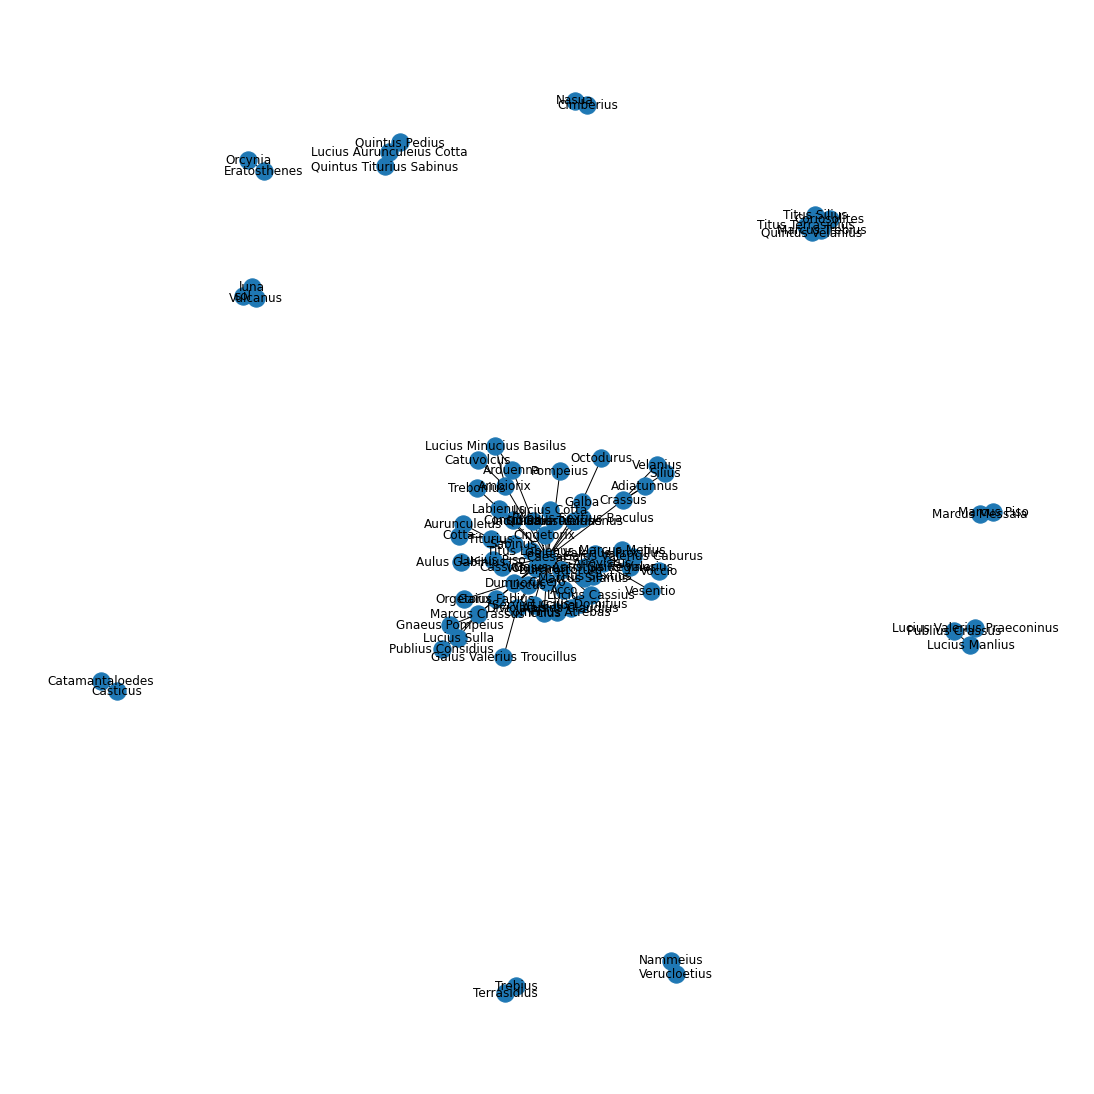

In [151]:
# VISUALIZATION
plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True) # with_labels=True for showing node's label
plt.show()

In [152]:
# from pyvis.network import Network
#
# net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color='white')
#
# net.from_nx(G)
# net.show("caes_net.html")

In [153]:
nx.write_gexf(G, "gephi_net.gexf")

## Measures

##### Find cliques

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html#networkx.algorithms.clique.find_cliques

In [154]:
cliques_list = (sorted(list(nx.find_cliques(G)), key=lambda x: len(x), reverse=True))
cliques_list

[['Gaius Valerius Caburus',
  'Gaius Valerius',
  'Marcus Metius',
  'Ariovistus',
  'Gaius Valerius Procillus'],
 ['Marcus Trebius',
  'Quintus Velanius',
  'Coriosolites',
  'Titus Silius',
  'Titus Terrasidius'],
 ['Caesar', 'Liscus', 'Diviciacus', 'Dumnorix'],
 ['Caesar', 'Gaius Antistius Reginus', 'Marcus Silanus', 'Titus Sextius'],
 ['Caesar', 'Galba', 'Gaius Volusenus', 'Publius Sextius Baculus'],
 ['sol', 'luna', 'Vulcanus'],
 ['Publius Considius', 'Lucius Sulla', 'Marcus Crassus'],
 ['Lucius Valerius Praeconinus', 'Publius Crassus', 'Lucius Manlius'],
 ['Lucius Minucius Basilus', 'Ambiorix', 'Arduenna'],
 ['Caesar', 'Lucius Cotta', 'Quintus Titurius'],
 ['Caesar', 'Appius Claudius', 'Lucius Domitius'],
 ['Caesar', 'Titurius', 'Sabinus'],
 ['Caesar', 'Gaius Fabius', 'Marcus Crassus'],
 ['Caesar', 'Cassius', 'Lucius Piso'],
 ['Caesar', 'Acco', 'Durocortorum'],
 ['Caesar', 'Ariovistus', 'Gaius Valerius Procillus'],
 ['Caesar', 'Labienus', 'Considius'],
 ['Caesar', 'Indutiomarus',

##### Degree, degree centrality and closeness centrality

In order to understand if the most important character in the work are represented as such in the graph, we can look at the node's degree, degree centrality and closeness centrality. These measures are relevant on the assumption that important actors are involved in a higher number of interactions with others, and that they are able to communicate more easily with most of the nodes.

In [155]:
degrees = nx.degree(G) # high number of interactions for important nodes
degree_centrality = nx.degree_centrality(G) # more interactions for important nodes
closeness_centrality = nx.closeness_centrality(G) # easy communication of important nodes

In [156]:
# DEGREE
print(sorted(degrees, key=lambda x: x[1], reverse=True))

[('Caesar', 36), ('Ariovistus', 7), ('Marcus Crassus', 5), ('Gaius Valerius Procillus', 5), ('Dumnorix', 4), ('Diviciacus', 4), ('Gaius Valerius Caburus', 4), ('Gaius Valerius', 4), ('Marcus Metius', 4), ('Titurius', 4), ('Galba', 4), ('Titus Terrasidius', 4), ('Marcus Trebius', 4), ('Coriosolites', 4), ('Quintus Velanius', 4), ('Titus Silius', 4), ('Crassus', 4), ('Ambiorix', 4), ('Lucius Piso', 3), ('Liscus', 3), ('Labienus', 3), ('Publius Sextius Baculus', 3), ('Gaius Volusenus', 3), ('Quintus Titurius', 3), ('Indutiomarus', 3), ('Arduenna', 3), ('Marcus Silanus', 3), ('Gaius Antistius Reginus', 3), ('Titus Sextius', 3), ('Cassius', 2), ('Publius Considius', 2), ('Lucius Sulla', 2), ('Considius', 2), ('Lucius Aurunculeius Cotta', 2), ('Silius', 2), ('Velanius', 2), ('Sabinus', 2), ('Publius Crassus', 2), ('Lucius Valerius Praeconinus', 2), ('Lucius Manlius', 2), ('Lucius Cotta', 2), ('Lucius Domitius', 2), ('Appius Claudius', 2), ('Cingetorix', 2), ('Gaius Fabius', 2), ('sol', 2), (

In [157]:
# DEGREE CENTRALITY
print(sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.42857142857142855), ('Ariovistus', 0.08333333333333333), ('Marcus Crassus', 0.05952380952380952), ('Gaius Valerius Procillus', 0.05952380952380952), ('Dumnorix', 0.047619047619047616), ('Diviciacus', 0.047619047619047616), ('Gaius Valerius Caburus', 0.047619047619047616), ('Gaius Valerius', 0.047619047619047616), ('Marcus Metius', 0.047619047619047616), ('Titurius', 0.047619047619047616), ('Galba', 0.047619047619047616), ('Titus Terrasidius', 0.047619047619047616), ('Marcus Trebius', 0.047619047619047616), ('Coriosolites', 0.047619047619047616), ('Quintus Velanius', 0.047619047619047616), ('Titus Silius', 0.047619047619047616), ('Crassus', 0.047619047619047616), ('Ambiorix', 0.047619047619047616), ('Lucius Piso', 0.03571428571428571), ('Liscus', 0.03571428571428571), ('Labienus', 0.03571428571428571), ('Publius Sextius Baculus', 0.03571428571428571), ('Gaius Volusenus', 0.03571428571428571), ('Quintus Titurius', 0.03571428571428571), ('Indutiomarus', 0.03571428571428571),

In [158]:
# CLOSENESS CENTRALITY
print(sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.5005952380952381), ('Ariovistus', 0.31783824640967495), ('Gaius Valerius Procillus', 0.3128720238095238), ('Marcus Crassus', 0.3080586080586081), ('Crassus', 0.30570701563067976), ('Ambiorix', 0.30570701563067976), ('Dumnorix', 0.3033910533910534), ('Diviciacus', 0.3033910533910534), ('Titurius', 0.3033910533910534), ('Liscus', 0.301109917651271), ('Galba', 0.301109917651271), ('Indutiomarus', 0.301109917651271), ('Gaius Fabius', 0.301109917651271), ('Lucius Piso', 0.29886282871357495), ('Labienus', 0.29886282871357495), ('Publius Sextius Baculus', 0.29886282871357495), ('Gaius Volusenus', 0.29886282871357495), ('Sabinus', 0.29886282871357495), ('Quintus Titurius', 0.29886282871357495), ('Cassius', 0.2966490299823633), ('Considius', 0.2966490299823633), ('Lucius Cotta', 0.2966490299823633), ('Cingetorix', 0.2966490299823633), ('Marcus Silanus', 0.2966490299823633), ('Gaius Antistius Reginus', 0.2966490299823633), ('Titus Sextius', 0.2966490299823633), ('Lucius Domitius', 

##### Eigenvector centrality
The value of the Eigenvector centrality (centrality of a node based on the centrality of its neighbors) of each node can be interpreted as a measure of how “important” is each individual, since we would expect that “important” individuals (such as Caesar and other Roman generals) interact more frequently with other important individuals than they do with “minor” actors

In [159]:
# EIGENVECTOR CENTRALITY
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
print(sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True))

[('Caesar', 0.6551771880101828), ('Ariovistus', 0.2885563508757612), ('Gaius Valerius Procillus', 0.24172319393921013), ('Dumnorix', 0.18581743991175112), ('Quintus Titurius', 0.1838681603260261), ('Indutiomarus', 0.17018864828134056), ('Durocortorum', 0.1643410930250758), ('Volusenus', 0.15897946719975997), ('Titus Labienus', 0.15897946719975997), ('Titurius', 0.1438345550628472), ('Sabinus', 0.1292548057645692), ('Liscus', 0.12862553987062156), ('Lucius Piso', 0.1252082888474287), ('Cingetorix', 0.11975228661059704), ('Cicero', 0.10598631146650664), ('Marcus Silanus', 0.10296208856691537), ('Gaius Antistius Reginus', 0.10296208856691537), ('Titus Sextius', 0.10296208856691537), ('Lucius Cotta', 0.09761051509458549), ('Marcus Metius', 0.09500610009395473), ('Diviciacus', 0.09407286823360693), ('Publius Sextius Baculus', 0.09303881240358093), ('Galba', 0.08276516518544097), ('Gaius Volusenus', 0.08226420397057103), ('Marcus Crassus', 0.08098082184054012), ('Gaius Valerius Caburus', 0.0

##### Betweenness centrality and centralization
We compute betweennes centrality and see if a small number of nodes have much higher degree centrality values than the others  --> we plot a histogram!!

In [160]:
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
betweenness_centrality

{'Marcus Messala': 0.0,
 'Marcus Piso': 0.0,
 'Casticus': 0.0,
 'Catamantaloedes': 0.0,
 'Dumnorix': 0.016351118760757313,
 'Diviciacus': 0.03958691910499139,
 'Lucius Piso': 0.016351118760757313,
 'Aulus Gabinius': 0.0,
 'Nammeius': 0.0,
 'Verucloetius': 0.0,
 'Caesar': 0.4526678141135972,
 'Lucius Cassius': 0.0,
 'Orgetorix': 0.0,
 'Cassius': 0.0,
 'Liscus': 0.01606425702811245,
 'Gaius Valerius Troucillus': 0.0,
 'Publius Considius': 0.016351118760757313,
 'Lucius Sulla': 0.0,
 'Marcus Crassus': 0.04790590935169248,
 'Labienus': 0.016351118760757313,
 'Considius': 0.0,
 'Ariovistus': 0.037387645821380794,
 'Nasua': 0.0,
 'Cimberius': 0.0,
 'Vesentio': 0.0,
 'Gaius Valerius Procillus': 0.03977816026008795,
 'Gaius Valerius Caburus': 0.005115700898833427,
 'Gaius Valerius': 0.005115700898833427,
 'Marcus Metius': 0.0008605851979345954,
 'Voccio': 0.0,
 'Iccius': 0.0,
 'Titurius': 0.032415375788869764,
 'Quintus Pedius': 0.0,
 'Lucius Aurunculeius Cotta': 0.00028686173264486515,
 'Galb

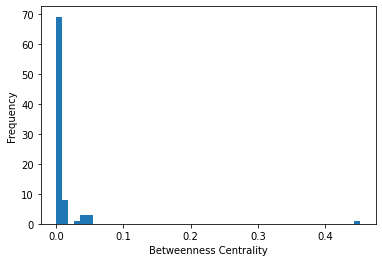

In [161]:
# Extract the betweenness centrality values from the dictionary
betweenness_centrality_values = list(betweenness_centrality.values())

# Create a histogram of the betweenness centrality values
plt.hist(betweenness_centrality_values, bins=50)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

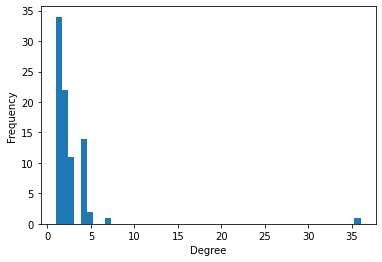

In [162]:
degree_list = [d[1] for d in list(nx.degree(G))]
plt.hist(degree_list, bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [163]:
density = nx.density(G)
# diameter = nx.diameter() # not possible, since the graph is disconnected https://stackoverflow.com/a/69636529/20184608
clustering_coefficient = nx.clustering(G, weight='weight')

In [164]:
# print(sorted(clustering_coefficient.items(), key=lambda x:x[1], reverse=True))


In [165]:
import pandas as pd

adj_matrix = nx.adjacency_matrix(G)
adj_matrix_df = pd.DataFrame.sparse.from_spmatrix(adj_matrix)

C:\Users\media\AppData\Local\Temp/ipykernel_2792/2379880176.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)
